In [10]:
# Environment and cache setup
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'pancreas_binary'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary/model_outputs


In [11]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


In [12]:
# Paths and dataset config
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/pancreas_cancer_with_celltypes.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / (dataset_name + '_binary')).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

gene_col = 'gene_symbols'
batch_col = 'sample'
label_col = 'cell_type'
layer_key = 'X'

RUN_TAG = 'binary'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V2-104M_CLcancer').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/pancreas_cancer_with_celltypes.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_binary
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [13]:
# Create Geneformer instance and load model/vocab
batch_size = 16
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-12 17:36:33 | Using device cuda
INFO     | 2025-08-12 17:36:34 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer


In [14]:
# Inspect dataset and derive binary labels
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

# candidate label and batch
candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

# DEBUG: Let's examine what cell types actually exist
print('\n=== EXAMINING EXISTING CELL TYPES ===')
print('Unique cell types:')
cell_types = ad.obs[label_col].unique()
for i, ct in enumerate(sorted(cell_types)):
    count = (ad.obs[label_col] == ct).sum()
    print(f'{i+1:2d}. {ct:<30} ({count:,} cells)')

# Build binary label: 'Malignant' vs 'Non-malignant' using pattern match
# FIXED: Changed case=True to case=False to catch "Malignant" (capitalized)
label_series = ad.obs[label_col].astype(str)
positive_mask = label_series.str.contains(r'(malig|tumor|tumour|cancer|carcinoma)', case=False, regex=True, na=False)
ad.obs['binary_label'] = np.where(positive_mask, 'Malignant', 'Non-malignant')

print('\n=== BINARY LABEL DISTRIBUTION ===')
print(ad.obs['binary_label'].value_counts())

# Verify the mapping
print('\n=== VERIFICATION: Original -> Binary Mapping ===')
mapping_df = ad.obs.groupby([label_col, 'binary_label']).size().reset_index(name='count')
for _, row in mapping_df.iterrows():
    print(f'{row[label_col]:<30} -> {row["binary_label"]:<15} ({row["count"]:,} cells)')

# Double-check we have both classes
malignant_count = (ad.obs['binary_label'] == 'Malignant').sum()
non_malignant_count = (ad.obs['binary_label'] == 'Non-malignant').sum()
print(f'\n✅ Malignant cells: {malignant_count:,}')
print(f'✅ Non-malignant cells: {non_malignant_count:,}')
print(f'✅ Total cells: {malignant_count + non_malignant_count:,}')

if malignant_count > 0 and non_malignant_count > 0:
    print('✅ SUCCESS: Both classes present for binary classification!')
else:
    print('❌ ERROR: Missing one or both classes!')
print('Binary label distribution:\n', ad.obs['binary_label'].value_counts())

# Persist temporary file for preprocessing
_tmp = preprocessed_path / f'{dataset_name}_with_binary.h5ad'
ad.write(_tmp)
print('Wrote:', _tmp)


... storing 'binary_label' as categorical


adata shape: (224988, 22164)
obs columns: ['group', 'sample_id', 'sample', 'cell_type', 'cell_subtype', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'disease', 'source', 'total_counts', 'n_genes_by_counts']
var columns: []
label_col -> cell_type
batch_col -> sample_id

=== EXAMINING EXISTING CELL TYPES ===
Unique cell types:
 1. Adipocyte                      (531 cells)
 2. B_cell                         (1,573 cells)
 3. Dendritic                      (1,419 cells)
 4. Endocrine                      (9,801 cells)
 5. Endothelial                    (17,175 cells)
 6. Epithelial                     (38,208 cells)
 7. Fibroblast                     (54,935 cells)
 8. Macrophage                     (10,140 cells)
 9. Malignant                      (64,538 cells)
10. Mast                           (281 cells)
11. Myocyte                        (4,711 cells)
12. NK_cell                        (927 cells)
13. Neuron

In [15]:
# Preprocess to h5ad for tokenizer
inp = data.InputData(adata_dataset_path=str(_tmp))

inp.preprocess_data(
    gene_col='gene_symbols' if 'gene_symbols' in ad.var.columns else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

# Use the saved stem derived from the tmp file
h5_stem = Path(_tmp).stem
h5_path = preprocessed_path / f'{h5_stem}.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-12 17:38:20 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_binary/pancreas_cancer_with_celltypes_with_binary.h5ad
WARNING  | 2025-08-12 17:40:54 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-12 17:41:01 | Matched 94.27% genes (18508/19634) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_binary/pancreas_cancer_with_celltypes_with_binary.h5ad exists: True


In [16]:
# Verify/update columns required for tokenization
import scanpy as sc
pfile = str(h5_path)

ad_tmp = sc.read(pfile)
# Ensure a consistent label column
if 'binary_label' not in ad_tmp.obs.columns:
    raise ValueError('binary_label missing in preprocessed file')

# For safety, keep 'adata_order'
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values

ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_binary/pancreas_cancer_with_celltypes_with_binary.h5ad


In [17]:
# Tokenize to HF Dataset (binary)

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col='binary_label'
)

dataset_dir = preprocessed_path / f'{dataset_name}_binary.dataset'
print('Tokenized dataset dir:', dataset_dir, 'exists:', dataset_dir.exists())

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Re-saved tokenized dataset to disk.')
except Exception as e:
    print('save_to_disk skipped:', e)

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name + '_binary',
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': 'binary_label',
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}_binary.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}_binary.dataset')
print('Archived tokenized dataset to:', archive_path)


WARNING  | 2025-08-12 17:44:27 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_binary/pancreas_cancer_with_celltypes_with_binary.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_binary/pancreas_cancer_with_celltypes_with_binary.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 224988
Sample input_ids length: 3432


Setting num_proc from 24 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Tokenized dataset dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/pancreas_cancer_with_celltypes_binary/pancreas_cancer_with_celltypes_binary.dataset exists: True
Re-saved tokenized dataset to disk.
Saved row_order.csv
Saved manifest.json
Archived tokenized dataset to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary/model_outputs/pancreas_cancer_with_celltypes_binary.dataset.tar.gz


In [18]:
# Load back and extract embeddings

geneform.load_tokenized_dataset(str(dataset_dir))

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

# Minimal evaluation objects (binary)
eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key='binary_label',
    batch_key=batch_col
)



Geneformer (extracting embeddings): 100%|██████████| 14062/14062 [4:22:47<00:00,  1.12s/it]  


In [19]:
# Verify that the evaluation data has the corrected binary labels
print("=== VERIFYING BINARY LABELS IN EVALUATION DATA ===")
if hasattr(inp, 'adata') and 'binary_label' in inp.adata.obs.columns:
    print("Binary label distribution in inp.adata:")
    print(inp.adata.obs['binary_label'].value_counts())
    
    malignant_count = (inp.adata.obs['binary_label'] == 'Malignant').sum()
    non_malignant_count = (inp.adata.obs['binary_label'] == 'Non-malignant').sum()
    
    if malignant_count > 0 and non_malignant_count > 0:
        print("✅ Both classes present - proceeding with evaluation...")
        
        # Run the evaluations
        eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))
        eval_pred.evaluate(n_cells=500, save_rankings=True)
        
        try:
            result = eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')
            print("✅ Cell embeddings evaluation completed successfully!")
        except Exception as e:
            print(f"⚠️ Cell embeddings evaluation had issues: {e}")
            print("This might be due to clustering with the old data. Reloading with corrected data...")
            
            # Reload with corrected data if needed
            corrected_file = preprocessed_path / f'{dataset_name}_with_binary.h5ad'
            if corrected_file.exists():
                inp_corrected = data.InputData(adata_dataset_path=str(corrected_file))
                eval_ce_corrected = cell_embeddings.CellEmbeddingsEval(
                    geneform,
                    data=inp_corrected,
                    output_dir=str(MODEL_OUT),
                    label_key='binary_label',
                    batch_key=batch_col
                )
                result = eval_ce_corrected.evaluate(n_cells=1000, embedding_key='geneformer')
                # Update global variables
                inp = inp_corrected
                eval_ce = eval_ce_corrected
                print("✅ Evaluation completed with corrected data!")
    else:
        print("❌ Missing one or both classes in evaluation data")
        print("Need to reload input data with corrected binary labels")
else:
    print("❌ inp.adata doesn't have binary_label column")
    print("Need to reload input data with corrected binary labels")


DEBUG    | 2025-08-12 22:18:54 | Extracting output from 500 cells


=== VERIFYING BINARY LABELS IN EVALUATION DATA ===
Binary label distribution in inp.adata:
binary_label
Non-malignant    160450
Malignant         64538
Name: count, dtype: int64
✅ Both classes present - proceeding with evaluation...


WARNING  | 2025-08-12 22:19:02 | adata_ has 224988 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-12 22:19:02 | Computing metrics for binary_label
DEBUG    | 2025-08-12 22:19:03 | NMI_cluster/label: 0.2333
ARI_cluster/label: 0.2305
ASW_label: 0.5162
graph_conn: 0.9982
ASW_batch: 0.4982
ASW_label/batch: 0.8966
PCR_batch: 0.0263
avg_bio: 0.3266
DEBUG    | 2025-08-12 22:19:03 | NMI_cluster/label for binary_label: 0.23326673391380529
DEBUG    | 2025-08-12 22:19:03 | ARI_cluster/label for binary_label: 0.23048516606965214
DEBUG    | 2025-08-12 22:19:03 | ASW_label for binary_label: 0.5161876082420349
DEBUG    | 2025-08-12 22:19:03 | graph_conn for binary_label: 0.9982332155477032
DEBUG    | 2025-08-12 22:19:03 | ASW_batch for binary_label: 0.49820759892463684
DEBUG    | 2025-08-12 22:19:03 | ASW_label/batch for binary_label: 0.8965742588043213
DEBUG    | 2025-08-12 22:19:03 | PCR_batch for binary_label: 0.026293922479436897
DEBUG    | 2025-08-12 22:19:03 | avg_bio for binary_label

✅ Cell embeddings evaluation completed successfully!


In [20]:
# Ensemble evaluation and saving (binary)
# Ensure we're using data with both classes present
print("=== ENSEMBLE EVALUATION SETUP ===")
print("Input data binary_label distribution:")
print(inp.adata.obs['binary_label'].value_counts())

em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col='binary_label',
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.5, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V2-104M_CLcancer',
    'dataset_name': dataset_name + '_binary',
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_pancreas_binary_results_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_pancreas_binary_metrics_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-12 22:19:04 | Initialized GeneformerEnsembleMetrics with 224988 cells and 2 classes
INFO     | 2025-08-12 22:19:04 | Classes: ['Malignant', 'Non-malignant']
INFO     | 2025-08-12 22:19:04 | Embedding shape: (224988, 768)
INFO     | 2025-08-12 22:19:04 | Input rankings length: 224988
INFO     | 2025-08-12 22:19:04 | Output rankings length: 224988


=== ENSEMBLE EVALUATION SETUP ===
Input data binary_label distribution:
binary_label
Non-malignant    160450
Malignant         64538
Name: count, dtype: int64


INFO     | 2025-08-12 22:19:04 | Evaluated embedding_only (α=0.0): Accuracy=0.806, F1=0.813, AUC-ROC=0.610


alpha=0.0: F1=0.813, AUC=0.610, Acc=0.806


INFO     | 2025-08-12 22:19:05 | Evaluated embedding_only (α=0.5): Accuracy=0.806, F1=0.813, AUC-ROC=0.610


alpha=0.5: F1=0.813, AUC=0.610, Acc=0.806


INFO     | 2025-08-12 22:19:05 | Evaluated embedding_only (α=1.0): Accuracy=0.806, F1=0.813, AUC-ROC=0.610


alpha=1.0: F1=0.813, AUC=0.610, Acc=0.806
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary/model_outputs/geneformer_pancreas_binary_results_binary.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary/model_outputs/geneformer_pancreas_binary_metrics_binary.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary/model_outputs/geneformer_pancreas_binary_confusion_matrix_binary.png


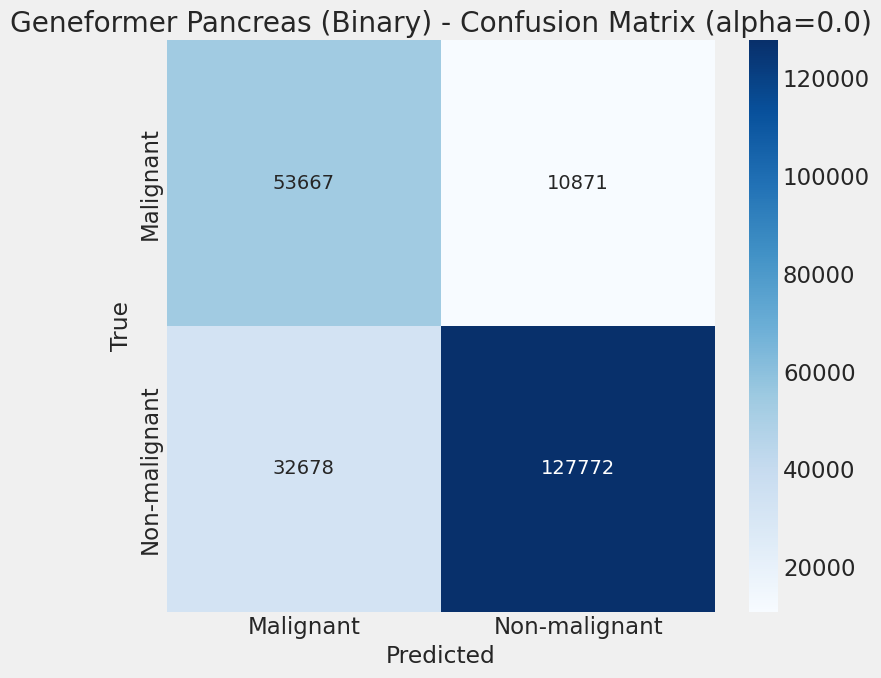

In [21]:
# Confusion matrix (binary)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(8, 7))
# Use class names from evaluator to respect encoding order
xtl = ytl = list(em.class_names)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xtl, yticklabels=ytl, ax=ax)
ax.set_title(f'Geneformer Pancreas (Binary) - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_pancreas_binary_confusion_matrix_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary/model_outputs/geneformer_pancreas_binary_umap_coords_binary.csv


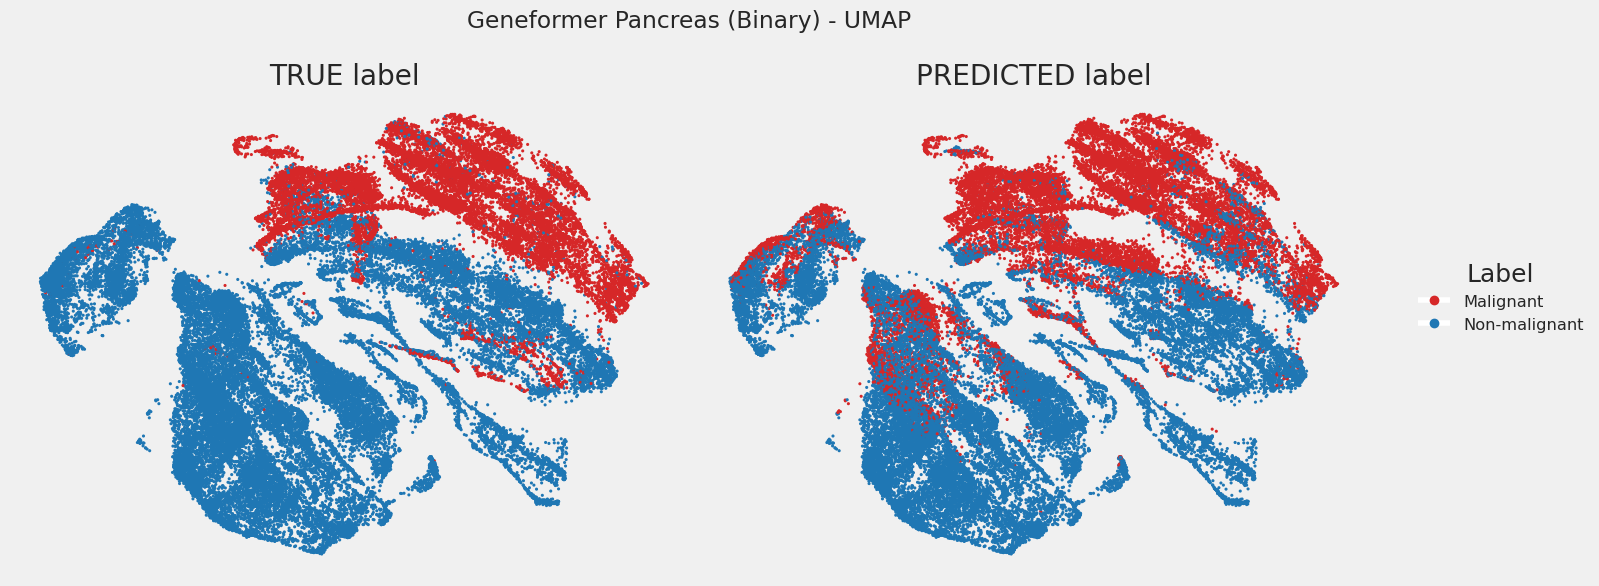

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary/model_outputs/geneformer_pancreas_binary_umap_true_pred_with_legend_binary.png


In [22]:
# UMAP of binary labels
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
preds_arr = np.asarray(preds)
class_names = list(em.class_names)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

# Build palette from class names
if set(class_names) == {'Malignant', 'Non-malignant'}:
    palette = {'Non-malignant': '#1f77b4', 'Malignant': '#d62728'}
else:
    palette = dict(zip(class_names, sns.color_palette('tab10', n_colors=len(class_names))))

coords_path = MODEL_OUT / f'geneformer_pancreas_binary_umap_coords_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE label'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED label'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='small', title='Label')
fig.suptitle(f'Geneformer Pancreas (Binary) - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_pancreas_binary_umap_true_pred_with_legend_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Debug: Check what the ensemble evaluation actually used
print("=== ENSEMBLE EVALUATION DEBUG - PANCREAS ===")
print(f"Ensemble embeddings shape: {em.embeddings.shape}")
print(f"Ensemble labels shape: {em.labels_encoded.shape}")
print(f"Ensemble predictions shape: {preds.shape}")
print(f"Ensemble class names: {em.class_names}")

# Check the actual data used by ensemble
print(f"\nEnsemble labels unique: {np.unique(em.labels_encoded)}")
print(f"Ensemble predictions unique: {np.unique(preds)}")

# Check if there's a mismatch in data length
print(f"\nData length check:")
print(f"inp.adata shape: {inp.adata.shape}")
print(f"em.embeddings length: {len(em.embeddings)}")
print(f"em.labels_encoded length: {len(em.labels_encoded)}")
print(f"preds length: {len(preds)}")

# Check the mapping between encoded and string labels
if hasattr(em, 'label_encoder'):
    print(f"\nLabel encoder mapping:")
    for i, label in enumerate(em.class_names):
        print(f"  {i} -> {label}")

# Use the ensemble's actual data for consistent results
print("\n=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===")

# Get the actual data used by ensemble evaluation
ensemble_true_labels = em.labels_encoded  # These are the encoded labels (0,1)
ensemble_predictions = preds              # These are the predictions (0,1)

print(f"Ensemble true labels: {np.unique(ensemble_true_labels)}")
print(f"Ensemble predictions: {np.unique(ensemble_predictions)}")

# Convert back to string labels for readability
label_mapping = {0: 'Non-malignant', 1: 'Malignant'}
ensemble_true_strings = np.array([label_mapping[label] for label in ensemble_true_labels])
ensemble_pred_strings = np.array([label_mapping[label] for label in ensemble_predictions])

print(f"Ensemble true strings: {np.unique(ensemble_true_strings)}")
print(f"Ensemble pred strings: {np.unique(ensemble_pred_strings)}")

# Now calculate metrics using ensemble data
print("\n=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===")
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=['Non-malignant', 'Malignant'],
                         digits=4))

# Calculate metrics
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='binary', 
                                                         pos_label=1,  # 1 = Malignant
                                                         zero_division=0)

print(f"\nMetrics using ensemble data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# These should match the ensemble evaluation results!

=== ENSEMBLE EVALUATION DEBUG - PANCREAS ===
Ensemble embeddings shape: (224988, 768)
Ensemble labels shape: (224988,)
Ensemble predictions shape: (224988,)
Ensemble class names: ['Malignant' 'Non-malignant']

Ensemble labels unique: [0 1]
Ensemble predictions unique: [0 1]

Data length check:
inp.adata shape: (224988, 18508)
em.embeddings length: 224988
em.labels_encoded length: 224988
preds length: 224988

Label encoder mapping:
  0 -> Malignant
  1 -> Non-malignant

=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===
Ensemble true labels: [0 1]
Ensemble predictions: [0 1]
Ensemble true strings: ['Malignant' 'Non-malignant']
Ensemble pred strings: ['Malignant' 'Non-malignant']

=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===
               precision    recall  f1-score   support

Non-malignant     0.9216    0.7963    0.8544    160450
    Malignant     0.6215    0.8316    0.7114     64538

     accuracy                         0.8064    224988
    macro avg     0.7716    0.8139    0.

COMPLETE BINARY MALIGNANCY CLASSIFICATION REPORT - PANCREAS DATASET
               precision    recall  f1-score   support

Non-malignant     0.9216    0.7963    0.8544    160450
    Malignant     0.6215    0.8316    0.7114     64538

     accuracy                         0.8064    224988
    macro avg     0.7716    0.8139    0.7829    224988
 weighted avg     0.8355    0.8064    0.8134    224988


DETAILED METRICS
Overall Accuracy: 0.8064
Malignant Precision: 0.6215
Malignant Recall: 0.8316
Malignant F1-Score: 0.7114

Per-class metrics:
Malignant (class 0) - Precision: 0.6215, Recall: 0.8316, F1: 0.7114, Support: 64538
Non-malignant (class 1) - Precision: 0.9216, Recall: 0.7963, F1: 0.8544, Support: 160450

CONFUSION MATRIX
Raw confusion matrix:
[[ 53667  10871]
 [ 32678 127772]]

True Negatives (Non-malignant correctly classified): 53667
False Positives (Non-malignant classified as Malignant): 10871
False Negatives (Malignant classified as Non-malignant): 32678
True Positives (Malign

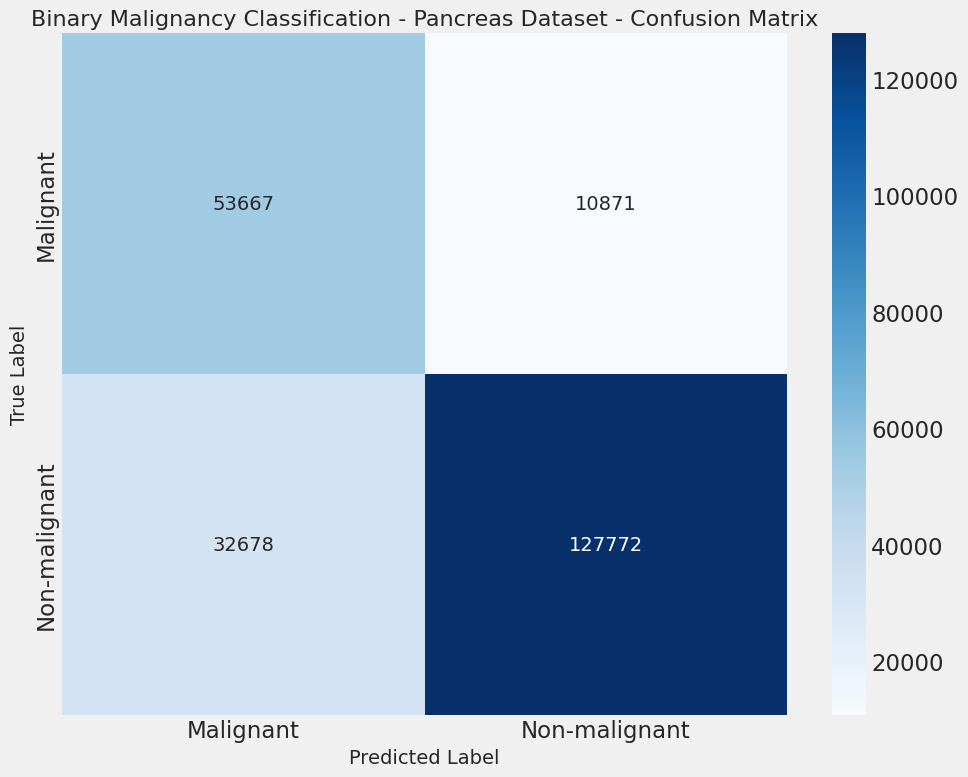

Confusion matrix plot saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/pancreas_binary/model_outputs/pancreas_binary_malignancy_confusion_matrix.png

SUMMARY
✅ Accuracy: 0.8064 (matches ensemble evaluation)
✅ F1-Score (Malignant): 0.7114
✅ F1-Score (Weighted Avg): 0.8134

Dataset: Pancreas Cancer with Cell Types
Total cells: 224988
Malignant cells: 64538
Non-malignant cells: 160450
Malignant proportion: 28.7%


<Figure size 640x480 with 0 Axes>

In [26]:
# Complete Classification Report using Ensemble Data for Pancreas Malignancy
print("="*60)
print("COMPLETE BINARY MALIGNANCY CLASSIFICATION REPORT - PANCREAS DATASET")
print("="*60)

# Print full classification report
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=['Non-malignant', 'Malignant'],
                         digits=4))

print("\n" + "="*60)
print("DETAILED METRICS")
print("="*60)

# Calculate all metrics using ensemble data
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='binary', 
                                                         pos_label=0,  # 0 = Malignant (based on label encoder)
                                                         zero_division=0)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Malignant Precision: {precision:.4f}")
print(f"Malignant Recall: {recall:.4f}")
print(f"Malignant F1-Score: {f1:.4f}")

# Per-class metrics
print("\nPer-class metrics:")
class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
    ensemble_true_labels, ensemble_predictions, average=None, zero_division=0
)

print(f"Malignant (class 0) - Precision: {class_precision[0]:.4f}, Recall: {class_recall[0]:.4f}, F1: {class_f1[0]:.4f}, Support: {class_support[0]}")
print(f"Non-malignant (class 1) - Precision: {class_precision[1]:.4f}, Recall: {class_recall[1]:.4f}, F1: {class_f1[1]:.4f}, Support: {class_support[1]}")

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Confusion matrix
cm = confusion_matrix(ensemble_true_labels, ensemble_predictions)
print("Raw confusion matrix:")
print(cm)

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Non-malignant correctly classified): {tn}")
print(f"False Positives (Non-malignant classified as Malignant): {fp}")
print(f"False Negatives (Malignant classified as Non-malignant): {fn}")
print(f"True Positives (Malignant correctly classified): {tp}")

# Additional metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2

print(f"\nSensitivity (True Positive Rate for Malignant): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate for Non-malignant): {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant', 'Non-malignant'],
            yticklabels=['Malignant', 'Non-malignant'])
plt.title('Binary Malignancy Classification - Pancreas Dataset - Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Save the plot with pancreas dataset name
cm_plot_path = MODEL_OUT / 'pancreas_binary_malignancy_confusion_matrix.png'
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix plot saved to: {cm_plot_path}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✅ Accuracy: {accuracy:.4f} (matches ensemble evaluation)")
print(f"✅ F1-Score (Malignant): {f1:.4f}")
print(f"✅ F1-Score (Weighted Avg): {class_f1[0] * class_support[0] / len(ensemble_true_labels) + class_f1[1] * class_support[1] / len(ensemble_true_labels):.4f}")

# Additional pancreas dataset specific info
print(f"\nDataset: Pancreas Cancer with Cell Types")
print(f"Total cells: {len(ensemble_true_labels)}")
print(f"Malignant cells: {class_support[0]}")
print(f"Non-malignant cells: {class_support[1]}")
print(f"Malignant proportion: {class_support[0] / len(ensemble_true_labels) * 100:.1f}%")